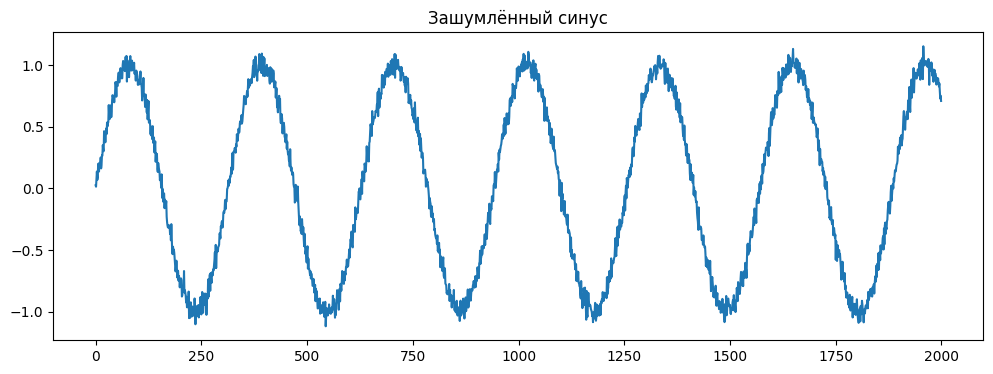

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(42)
t = np.linspace(0, 40, 2000)
clean = np.sin(t)
noise = np.random.normal(0, 0.05, len(t))
signal = clean + noise

plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title("Зашумлённый синус")
plt.show()

In [2]:
def create_dataset(series, window=40):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

WINDOW = 40
X, y = create_dataset(signal, WINDOW)

X = X[..., np.newaxis]  # (N, W) -> (N, W, 1)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [3]:
class RNNModel(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # финальный шаг
        out = self.fc(out)
        return out

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, hidden1=64, hidden2=32):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [5]:
def train_model(model, X_train, y_train, epochs=21):
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(X_train).squeeze()
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 3 == 0:
            print(f"Epoch {epoch+1}/{epochs} | loss = {loss.item():.4f}")

    return model

In [6]:
rnn = RNNModel()
print(rnn)

RNNModel(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [7]:
lstm = LSTMModel()
print(lstm)

LSTMModel(
  (lstm1): LSTM(1, 64, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [8]:
print("\nTraining RNN...")
rnn = train_model(rnn, X_train, y_train)


Training RNN...
Epoch 3/21 | loss = 0.5438
Epoch 6/21 | loss = 0.4894
Epoch 9/21 | loss = 0.4436
Epoch 12/21 | loss = 0.4020
Epoch 15/21 | loss = 0.3620
Epoch 18/21 | loss = 0.3222
Epoch 21/21 | loss = 0.2817


In [9]:
print("\nTraining LSTM... ")
lstm = train_model(lstm, X_train, y_train)


Training LSTM... 
Epoch 3/21 | loss = 0.5044
Epoch 6/21 | loss = 0.4778
Epoch 9/21 | loss = 0.4498
Epoch 12/21 | loss = 0.4159
Epoch 15/21 | loss = 0.3699
Epoch 18/21 | loss = 0.3033
Epoch 21/21 | loss = 0.2087


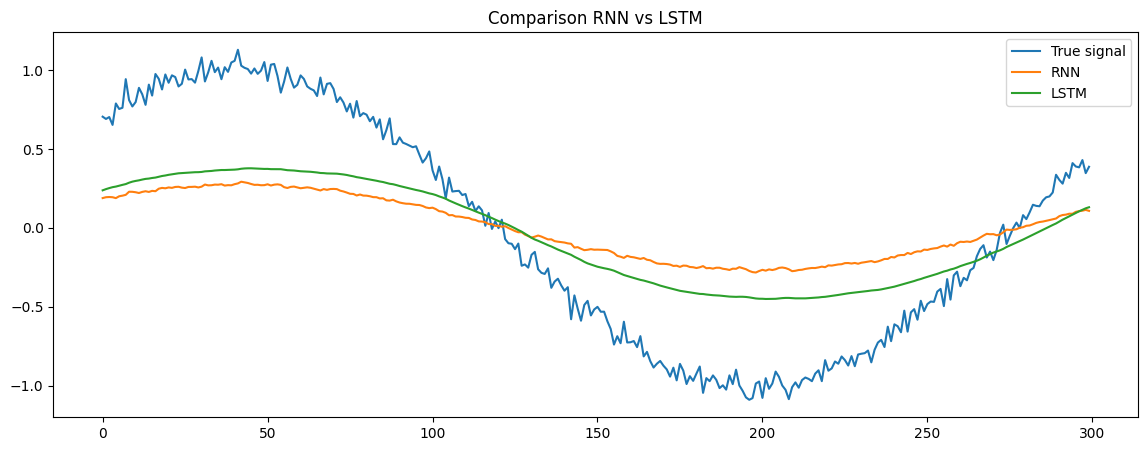

In [10]:
rnn.eval()
lstm.eval()

with torch.no_grad():
    rnn_pred = rnn(X_test).squeeze().numpy()
    lstm_pred = lstm(X_test).squeeze().numpy()

plt.figure(figsize=(14, 5))
plt.plot(y_test[:300], label="True signal")
plt.plot(rnn_pred[:300], label="RNN")
plt.plot(lstm_pred[:300], label="LSTM")
plt.title("Comparison RNN vs LSTM")
plt.legend()
plt.show()